In [18]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from nbimporter import NotebookLoader
from pinns_model_new import EVRangePINN   
import os

#####  CONFIGURATION


In [19]:
DATA_PATH = r"G:\My Drive\ev range prediction project agni\Project EV range prediction\Simulation\output\ev_sumo_dataset_16features.csv"
MODEL_PATH = r"G:\My Drive\ev range prediction project agni\Project EV range prediction\Scripts\15_07_model.pth"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##### LOAD DATA

In [20]:
print("\n Loading SUMO validation dataset...")
df = pd.read_csv(DATA_PATH)
print(f" Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Extract features (X) and targets (y)
X = df.iloc[:, :16].values
y_soc = df["SOC"].values
y_power = df["power_kw"].values

# Convert to tensor
X = np.nan_to_num(X, nan=0.0, posinf=1e3, neginf=-1e3)
X = np.clip(X, -1e3, 1e3)

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(DEVICE)



 Loading SUMO validation dataset...
 Dataset loaded: 470807 rows, 18 columns


##### LOAD TRAINED MODEL

In [21]:
print("\n Loading trained PINN model...")
model = EVRangePINN(input_size=16).to(DEVICE)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

print(" Model loaded successfully.")


 Loading trained PINN model...


C:\Users\DELL\AppData\Local\Temp\ipykernel_121924\565325868.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


 Model loaded successfully.


#####  RUN PREDICTIONS
 

In [22]:
batch_size = 1024  # adjust based on VRAM, try 512 or 256 if still OOM
soc_preds, power_preds = [], []

with torch.no_grad():
    for i in range(0, len(X_tensor), batch_size):
        X_batch = X_tensor[i:i+batch_size].to(DEVICE)
        preds = model(X_batch)

        # Replace NaNs or inf with zeros (safe fallback)
        soc_batch = torch.nan_to_num(preds['soc'], nan=0.0, posinf=1.0, neginf=0.0).squeeze().cpu().numpy()
        power_batch = torch.nan_to_num(preds['power'], nan=0.0, posinf=0.0, neginf=0.0).squeeze().cpu().numpy()

        soc_preds.append(soc_batch)
        power_preds.append(power_batch)

soc_pred = np.concatenate(soc_preds)
power_pred = np.concatenate(power_preds)


In [23]:
print("Tensor range check → min:", X_tensor.min().item(), "max:", X_tensor.max().item())


Tensor range check → min: 0.0 max: 327.1864318847656


In [24]:
print("\n🔍 Checking for NaNs...")
print("y_soc NaN count:", np.isnan(y_soc).sum())
print("soc_pred NaN count:", np.isnan(soc_pred).sum())
print("y_power NaN count:", np.isnan(y_power).sum())
print("power_pred NaN count:", np.isnan(power_pred).sum())



🔍 Checking for NaNs...
y_soc NaN count: 0
soc_pred NaN count: 0
y_power NaN count: 0
power_pred NaN count: 0


##### EVALUATE PERFORMANCE

In [26]:
soc_mae = mean_absolute_error(y_soc, soc_pred)
soc_r2 = r2_score(y_soc, soc_pred)

power_mae = mean_absolute_error(y_power, power_pred)
power_r2 = r2_score(y_power, power_pred)

print("\n Validation Metrics:")
print(f"   SOC  → MAE: {soc_mae:.4f}, R²: {soc_r2:.3f}")
print(f"   Power → MAE: {power_mae:.4f} kW, R²: {power_r2:.3f}")



 Validation Metrics:
   SOC  → MAE: 0.0767, R²: 0.000
   Power → MAE: 0.4706 kW, R²: 0.000


##### PLOTTING RESULTS

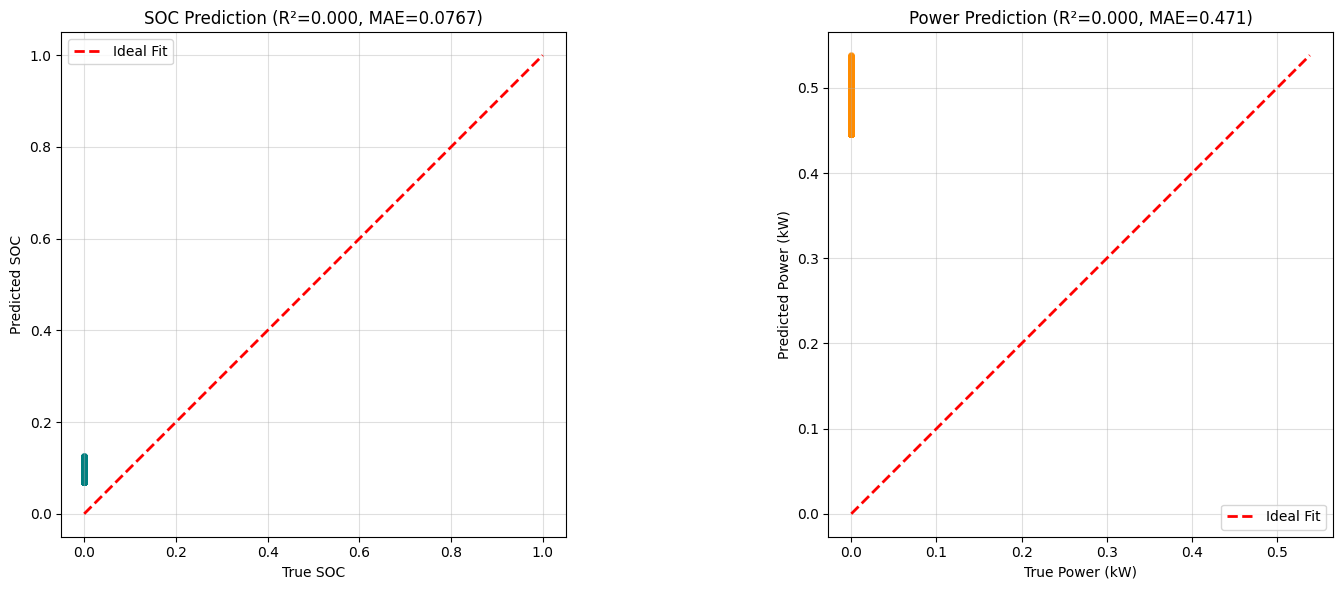


✅ Validation complete — plots displayed successfully.


In [28]:
plt.figure(figsize=(16, 6))

# ---- SOC Scatter ----
plt.subplot(1, 2, 1)
plt.scatter(y_soc, soc_pred, alpha=0.6, s=15, color='teal')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ideal Fit')
plt.xlabel("True SOC")
plt.ylabel("Predicted SOC")
plt.title(f"SOC Prediction (R²={soc_r2:.3f}, MAE={soc_mae:.4f})")
plt.legend()
plt.grid(True, alpha=0.4)
plt.axis("square")

# ---- Power Scatter ----
plt.subplot(1, 2, 2)
pmin, pmax = min(y_power.min(), power_pred.min()), max(y_power.max(), power_pred.max())
plt.scatter(y_power, power_pred, alpha=0.6, s=15, color='darkorange')
plt.plot([pmin, pmax], [pmin, pmax], 'r--', linewidth=2, label='Ideal Fit')
plt.xlabel("True Power (kW)")
plt.ylabel("Predicted Power (kW)")
plt.title(f"Power Prediction (R²={power_r2:.3f}, MAE={power_mae:.3f})")
plt.legend()
plt.grid(True, alpha=0.4)
plt.axis("square")

plt.tight_layout()
plt.show()

print("\n✅ Validation complete — plots displayed successfully.")